# TFM - CÓDIGO - CLAUDIA GÓMEZ ALONSO
## 2023-2024

El conjunto de datos con el que se va a trabajar procede de un estudio realizado en 2015 sobre habitantes de zonas rurales al oeste de Kenia. Dicha investigación, consistió en la realización de encuentas que recopilaban más de 70 rasgos de la vida personal de los usuarios, centrándose en aspectos económicos, sociales y de salud. Tras esto, se utilizó una herramienta de detección de depresión sobre los encuestados que, debemos tener claro, no sustituye el trabajo de un médico autorizado.

En este caso, se utilizará una muestra reducida del fichero original, que engloba una gran cantidad de datos, pero no tiene en cuenta las más de 70 variables, si no que se han extraído 24 de ellas. La primera, Survey_id, se ha eliminado desde el primer momento, dado que solo representa un número de identificación de cada encuesta y es diferente para cada persona, por lo que no nos aporta una información adicional que nos ayude a obtener los objetivos que tenemos.

## 0. Carga de librerías necesarias

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings
warnings.filterwarnings("ignore")

import statsmodels.api as sm
from xgboost import XGBClassifier

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, PowerTransformer, MinMaxScaler

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import Perceptron
from sklearn.svm import SVC

from sklearn.pipeline import make_pipeline, Pipeline

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, ShuffleSplit, LeaveOneOut, StratifiedKFold
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.decomposition import PCA

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, recall_score, precision_score
from sklearn.metrics import ConfusionMatrixDisplay, roc_auc_score, roc_curve, auc

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers

from  imblearn.over_sampling import SMOTE

## 1. Carga de los datos

In [2]:
df_depression = pd.read_csv("b_depressed.csv")

#Quitamos la columna de id del entrevistado, que no nos aporta información adicional
df_depression.drop(columns=['Survey_id'], inplace=True)
df_depression

,Ville_id,sex,Age,Married,Number_children,education_level,total_members,gained_asset,durable_asset,save_asset,...,incoming_salary,incoming_own_farm,incoming_business,incoming_no_business,incoming_agricultural,farm_expenses,labor_primary,lasting_investment,no_lasting_investmen,depressed
0,91,1,28,1,4,10,5,28912201,22861940,23399979,...,0,0,0,0,30028818,31363432,0,28411718,28292707.0,0
1,57,1,23,1,3,8,5,28912201,22861940,23399979,...,0,0,0,0,30028818,31363432,0,28411718,28292707.0,1
2,115,1,22,1,3,9,5,28912201,22861940,23399979,...,0,0,0,0,30028818,31363432,0,28411718,28292707.0,0
3,97,1,27,1,2,10,4,52667108,19698904,49647648,...,0,1,0,1,22288055,18751329,0,7781123,69219765.0,0
4,42,0,59,0,4,10,6,82606287,17352654,23399979,...,1,0,0,0,53384566,20731006,1,20100562,43419447.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1424,22,1,25,1,1,7,5,28912201,22861940,23399979,...,0,0,0,0,30028818,31363432,0,28411718,28292707.0,0
1425,69,1,28,1,4,10,6,15711078,24023054,15506558,...,0,1,0,0,23022095,1021536,0,1823477,47384361.0,0
1426,184,1,66,0,0,1,1,42440731,22861940,22562605,...,0,1,0,0,12545373,10454478,0,46444572,10454478.0,1
1427,75,1,51,1,1,12,5,28912201,22861940,23399979,...,0,0,0,0,30028818,31363432,0,28411718,28292707.0,0


## 2. Depuración de los datos

Observaremos si los tipos de datos asignados a todas nuestras variables son correctos:

In [3]:
df_depression.dtypes

Ville_id                   int64
sex                        int64
Age                        int64
Married                    int64
Number_children            int64
education_level            int64
total_members              int64
gained_asset               int64
durable_asset              int64
save_asset                 int64
living_expenses            int64
other_expenses             int64
incoming_salary            int64
incoming_own_farm          int64
incoming_business          int64
incoming_no_business       int64
incoming_agricultural      int64
farm_expenses              int64
labor_primary              int64
lasting_investment         int64
no_lasting_investmen     float64
depressed                  int64
dtype: object

Como tenemos una gran cantidad de variables dummys, conviene convertirlas a variables categóricas, ya que de manera automática se han interpretado como numéricas. Para ello, simplemente creamos una lista con las variables que debemos convertir, y le indicamos que deben ser de tipo str:

In [4]:
numericasACategóricas = ['Ville_id', 'sex', 'Married', 'incoming_salary', 'incoming_own_farm', 'incoming_business', 
                         'incoming_no_business', 'labor_primary', 'depressed']

for var in numericasACategóricas:
    df_depression[var] = df_depression[var].astype(str)

Comprobamos, llamando de nuevo a dtypes, si se ha producido el cambio, y ahora las variables categóricas son interpretadas como tal:

In [5]:
df_depression.dtypes

Ville_id                  object
sex                       object
Age                        int64
Married                   object
Number_children            int64
education_level            int64
total_members              int64
gained_asset               int64
durable_asset              int64
save_asset                 int64
living_expenses            int64
other_expenses             int64
incoming_salary           object
incoming_own_farm         object
incoming_business         object
incoming_no_business      object
incoming_agricultural      int64
farm_expenses              int64
labor_primary             object
lasting_investment         int64
no_lasting_investmen     float64
depressed                 object
dtype: object

Pasamos ahora a explorar de cierto modo los datos, para comprobar que no hay datos que se salen de los rangos establecidos, ni datos erróneos que ensuciarían el estudio del dataset. Comenzamos describiendo las variables numéricas del conjunto de datos, para tener una visión genérica de lo que tenemos:

In [6]:
df_depression.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,1429.0,3.477747e+01,1.398622e+01,17.0,25.0,30.0,42.0,91.0
Number_children,1429.0,2.883135e+00,1.874472e+00,0.0,2.0,3.0,4.0,11.0
education_level,1429.0,8.687194e+00,2.923532e+00,1.0,8.0,9.0,10.0,19.0
total_members,1429.0,4.969209e+00,1.786317e+00,1.0,4.0,5.0,6.0,12.0
gained_asset,1429.0,3.363448e+07,2.003854e+07,325112.0,23269824.0,28912201.0,37172832.0,99127548.0
durable_asset,1429.0,2.717296e+07,1.815672e+07,162556.0,19298521.0,22861940.0,26569498.0,99615601.0
save_asset,1429.0,2.742471e+07,1.775137e+07,172966.0,23399979.0,23399979.0,23399979.0,99926758.0
living_expenses,1429.0,3.248257e+07,2.101528e+07,262919.0,20886711.0,26692283.0,38436887.0,99295282.0
other_expenses,1429.0,3.366632e+07,2.170266e+07,172966.0,20980135.0,28203066.0,40518887.0,99823799.0
incoming_agricultural,1429.0,3.451039e+07,2.077846e+07,325112.0,23222287.0,30028818.0,40038424.0,99789095.0


Observamos que los datos entran dentro de una lógica, por cómo son las variables. Podemos destacar, por ejemplo, que el rango de edad que se abarca es desde adolescentes a gente de edad anciana, por lo que contempla todos los grupos de edad, excepto prácticamente la infancia.

Para continuar con el análisis de los datos, empleamos dos funciones que nos servirán, una de ellas para poder entender un poco mejor cómo son las variables categóricas, y la otra para contar cuántos datos distintos tenemos de cada variable numérica, puesto que si es un número bajo, quizás haya que plantearse tratarla como categórica:

In [7]:
def analizar_variables_categoricas(datos):
    """
    Analiza variables categóricas en un DataFrame.

    Args:
        datos (DataFrame): El DataFrame que contiene los datos.

    Returns:
        dict: Un diccionario donde aparecen las diferentes categorias, sus frecuencias
        absolutas y relativas.
    """
    # Inicializar un diccionario para almacenar los resultados
    resultados = {}
    
    # Genera una lista con los nombres de las variables.
    variables = list(datos.columns) 
    
    # Seleccionar las columnas numéricas en el DataFrame
    numericas = datos.select_dtypes(include=['int', 'int32', 'int64','float', 'float32', 'float64']).columns

    # Seleccionar las columnas categóricas en el DataFrame
    categoricas = [variable for variable in variables if variable not in numericas]
    
    # Iterar a través de las variables categóricas
    for categoria in categoricas:
        # Verificar si la variable categórica existe en el DataFrame
        if categoria in datos.columns:
            # Crear un DataFrame de resumen para la variable categórica
            resumen = pd.DataFrame({
                'n': datos[categoria].value_counts(),             # Conteo de frecuencias
                '%': datos[categoria].value_counts(normalize=True)  # Porcentaje de frecuencias
            })
            resultados[categoria] = resumen  # Almacenar el resumen en el diccionario
        else:
            # Si la variable no existe en los datos, almacenar None en el diccionario
            resultados[categoria] = None
    
    return resultados

def cuentaDistintos(datos):
    """
    Cuenta valores distintos en cada variable numerica de un DataFrame.

    Args:
        datos (DataFrame): El DataFrame que contiene los datos.

    Returns:
        Dataframe: Un DataFrame con las variables y valores distintos en cada una de ellas
    """
    # Seleccionar las columnas numéricas en el DataFrame
    numericas = datos.select_dtypes(include=['int', 'int32', 'int64','float', 'float32', 'float64'])
    
    # Calcular la cantidad de valores distintos en cada columna numérica
    resultados = numericas.apply(lambda x: len(x.unique()))
    
    # Crear un DataFrame con los resultados
    resultado = pd.DataFrame({'Columna': resultados.index, 'Distintos': resultados.values})
    
    return resultado

In [8]:
analizar_variables_categoricas(df_depression)

{'Ville_id':            n         %
 Ville_id              
 15        24  0.016795
 17        21  0.014696
 23        21  0.014696
 7         20  0.013996
 8         19  0.013296
 ...       ..       ...
 255        1  0.000700
 229        1  0.000700
 263        1  0.000700
 141        1  0.000700
 291        1  0.000700
 
 [255 rows x 2 columns],
 'sex':         n         %
 sex                
 1    1312  0.918125
 0     117  0.081875,
 'Married':             n         %
 Married                
 1        1104  0.772568
 0         325  0.227432,
 'incoming_salary':                     n         %
 incoming_salary                
 0                1172  0.820154
 1                 257  0.179846,
 'incoming_own_farm':                       n         %
 incoming_own_farm                
 0                  1069  0.748076
 1                   360  0.251924,
 'incoming_business':                       n         %
 incoming_business                
 0                  1275  0.892232
 1   

Con los gráficos y los porcentajes observamos que, todas las variables menos Ville_id son dummys. En cuanto Ville_id, encontramos muchos pueblos de los que solo hay un dato. Podríamos agrupar los datos, de modo que quede más compensado pero no tenemos información sobre los pueblos, por lo que sería una agrupación sin una lógica detrás. Es por ello que se ha decidido, al igual que sucedió al inicion con Survey_id, que vamos a eliminar esta variable del conjunto de datos.

In [9]:
df_depression.drop(columns=['Ville_id'], inplace=True)

Vamos ahora a comprobar si es necesario transformar alguna variable cuantitativa a categórica, si tiene pocos datos distintos:

In [10]:
cuentaDistintos(df_depression)

,Columna,Distintos
0,Age,71
1,Number_children,12
2,education_level,18
3,total_members,12
4,gained_asset,441
5,durable_asset,590
6,save_asset,268
7,living_expenses,411
8,other_expenses,615
9,incoming_agricultural,330


Vemos que las variables Number_children, education_level y total_members, en realidad no tienen demasiados datos distintos. Tiene sentido, por el campo al que representan, que se traten como variables categóricas. En este caso, se ha decidido que para la variable number_children se subdividirá en 3 categorías: de 0-2 hijos, de 3-5 hijos y > 5 hijos; por otro lado, subdividiremos education_level en 4 categorías: Sin Estudios, Estudios Básicos, Estudios Avanzados, Estudios Superiores; y la variable total_members en 0-5, 6-10 y > 10.

In [11]:
# 1. Number_children

rangos_hijos = [0, 3, 6, float('inf')]
categorias_hijos = ['0-2', '3-5', '>5']

df_depression['Number_children'] = pd.cut(df_depression['Number_children'], bins=rangos_hijos, labels=categorias_hijos, right=False)

# 2. education_level

rangos_ed = [0, 1, 9, 14, float('inf')]
categorias_ed = ['Sin Estudios', 'Estudios Básicos', 'Estudios Avanzados', 'Estudios Superiores']

df_depression['education_level'] = pd.cut(df_depression['education_level'], bins=rangos_ed, labels=categorias_ed, right=False)

# 3. total_members

rangos_members = [0, 6, 10, float('inf')]
categorias_members = ['0-5', '6-9', '>9']

df_depression['total_members'] = pd.cut(df_depression['total_members'], bins=rangos_members, labels=categorias_members, right=False)
df_depression

,sex,Age,Married,Number_children,education_level,total_members,gained_asset,durable_asset,save_asset,living_expenses,...,incoming_salary,incoming_own_farm,incoming_business,incoming_no_business,incoming_agricultural,farm_expenses,labor_primary,lasting_investment,no_lasting_investmen,depressed
0,1,28,1,3-5,Estudios Avanzados,0-5,28912201,22861940,23399979,26692283,...,0,0,0,0,30028818,31363432,0,28411718,28292707.0,0
1,1,23,1,3-5,Estudios Básicos,0-5,28912201,22861940,23399979,26692283,...,0,0,0,0,30028818,31363432,0,28411718,28292707.0,1
2,1,22,1,3-5,Estudios Avanzados,0-5,28912201,22861940,23399979,26692283,...,0,0,0,0,30028818,31363432,0,28411718,28292707.0,0
3,1,27,1,0-2,Estudios Avanzados,0-5,52667108,19698904,49647648,397715,...,0,1,0,1,22288055,18751329,0,7781123,69219765.0,0
4,0,59,0,3-5,Estudios Avanzados,6-9,82606287,17352654,23399979,80877619,...,1,0,0,0,53384566,20731006,1,20100562,43419447.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1424,1,25,1,0-2,Estudios Básicos,0-5,28912201,22861940,23399979,26692283,...,0,0,0,0,30028818,31363432,0,28411718,28292707.0,0
1425,1,28,1,3-5,Estudios Avanzados,6-9,15711078,24023054,15506558,10476722,...,0,1,0,0,23022095,1021536,0,1823477,47384361.0,0
1426,1,66,0,0-2,Estudios Básicos,0-5,42440731,22861940,22562605,12545372,...,0,1,0,0,12545373,10454478,0,46444572,10454478.0,1
1427,1,51,1,0-2,Estudios Avanzados,0-5,28912201,22861940,23399979,26692283,...,0,0,0,0,30028818,31363432,0,28411718,28292707.0,0


Trataremos ahora los datos missing, para finalizar nuestra limpieza del fichero de datos. 

In [12]:
df_depression.isnull().sum()

sex                       0
Age                       0
Married                   0
Number_children           0
education_level           0
total_members             0
gained_asset              0
durable_asset             0
save_asset                0
living_expenses           0
other_expenses            0
incoming_salary           0
incoming_own_farm         0
incoming_business         0
incoming_no_business      0
incoming_agricultural     0
farm_expenses             0
labor_primary             0
lasting_investment        0
no_lasting_investmen     20
depressed                 0
dtype: int64

Encontramos que, para la variable no_lasting_investment tenemos 20 datos perdidos. Aquí tenemos dos opciones, o bien eliminar esos 20 datos, o imputarlos. Dado que algunos de los modelos que se pretenden utilizar para entrenar con estos datos, requieren que las variables input no tengan ningún dato missing, se ha decidido imputar los datos, en este caso con la media de los mismos.

In [13]:
imputer = SimpleImputer(strategy="mean")
var = df_depression[['no_lasting_investmen']]
var_new = imputer.fit_transform(var)

df_depression['no_lasting_investmen'] = var_new

Y comprobamos si ya no hay ningun valor perdido:

In [14]:
df_depression.isnull().sum()

sex                      0
Age                      0
Married                  0
Number_children          0
education_level          0
total_members            0
gained_asset             0
durable_asset            0
save_asset               0
living_expenses          0
other_expenses           0
incoming_salary          0
incoming_own_farm        0
incoming_business        0
incoming_no_business     0
incoming_agricultural    0
farm_expenses            0
labor_primary            0
lasting_investment       0
no_lasting_investmen     0
depressed                0
dtype: int64

### 2.1 Observación gráfica de los datos depurados

Vamos a observar en este apartado, la distribución de las distintas variables, tanto categóricas como numéricas y veremos cómo se relacionan con la variable objetivo:

In [15]:
cat_cols = ['sex', 'Married', 'Number_children', 'education_level', 'total_members', 'incoming_salary',
            'incoming_own_farm', 'incoming_business', 'incoming_no_business', 'labor_primary']

num_cols = ['Age', 'gained_asset', 'durable_asset', 'save_asset','living_expenses', 'other_expenses','incoming_agricultural',
             'farm_expenses', 'lasting_investment', 'no_lasting_investmen']

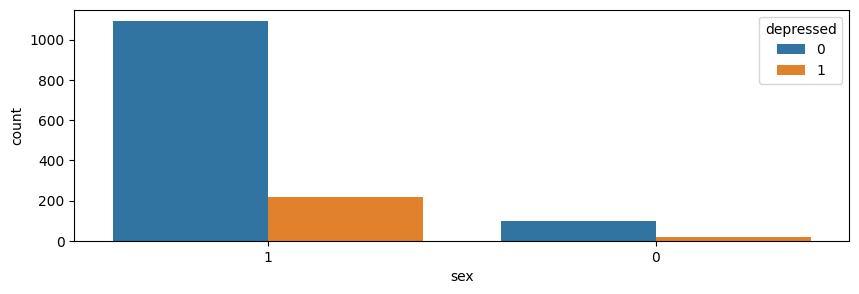

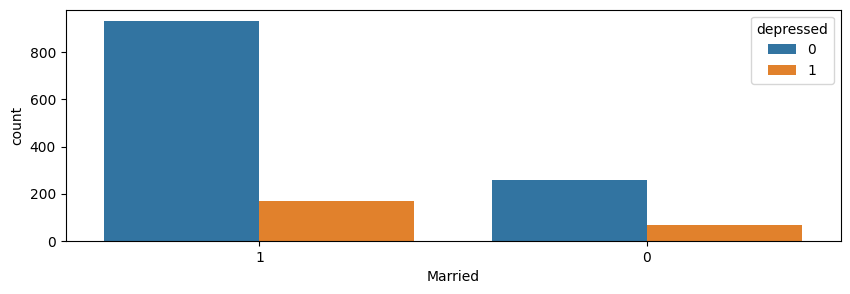

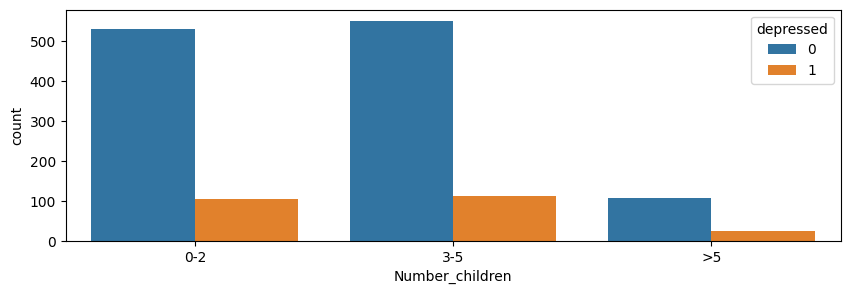

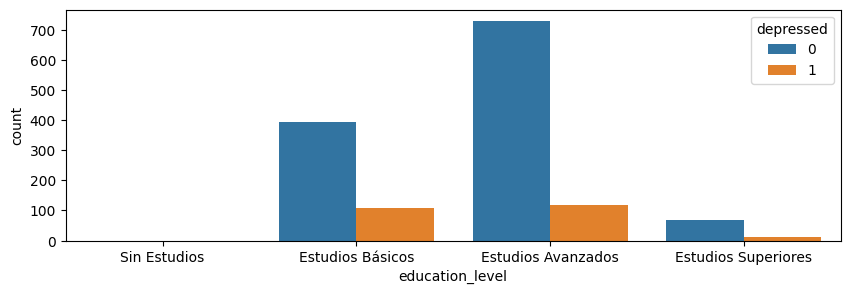

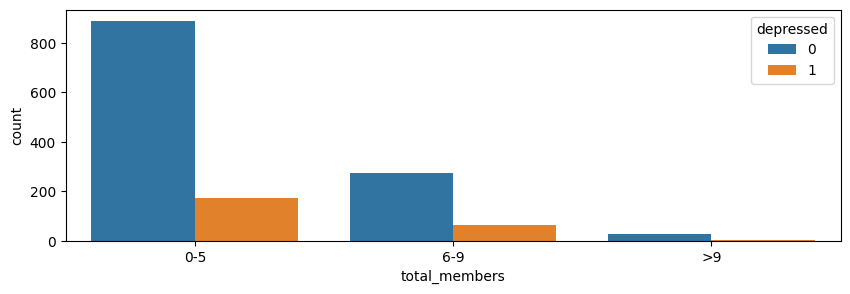

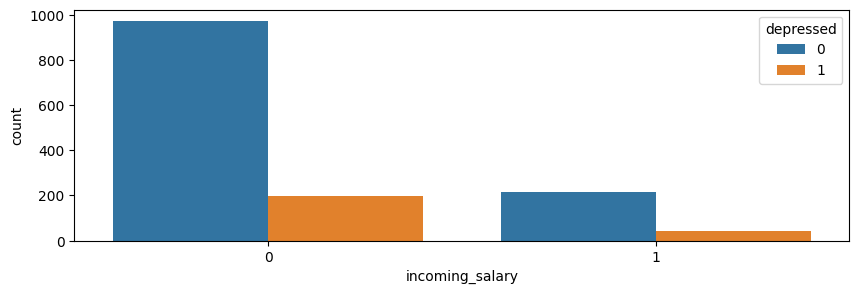

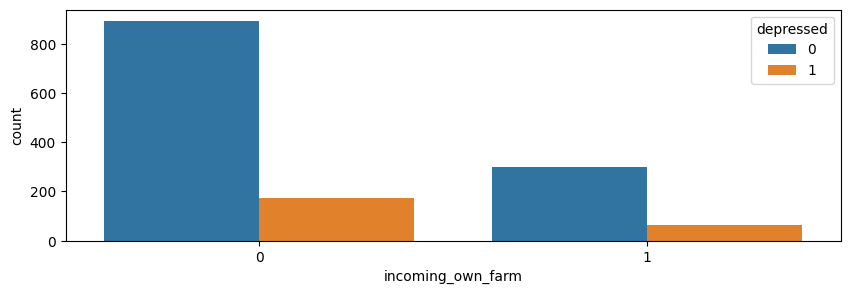

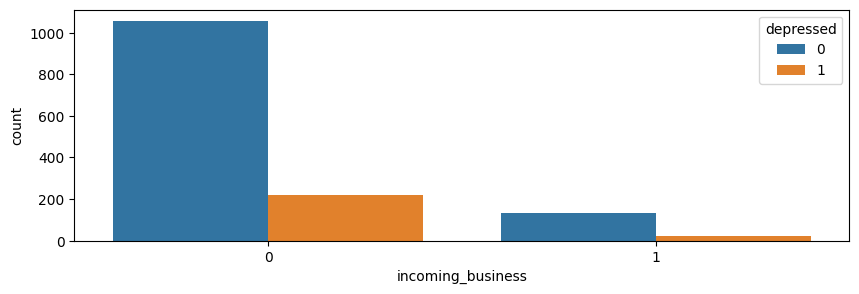

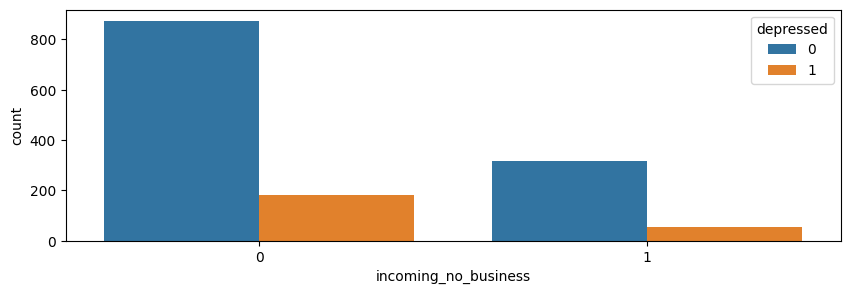

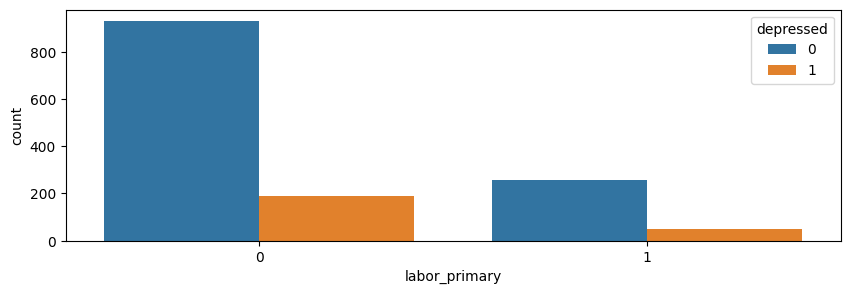

In [16]:
# 1. Variables categóricas
for col in cat_cols:
    plt.figure(figsize=(10,3))
    sns.countplot(data=df_depression, x=col, hue = "depressed")
    plt.show()

Al ver estas gráficas nos damos cuenta de que no hay una distinción demasiado clara entre unas categorías y otras, para determinar si hay un tipo de características que hacen que alguien sea más propenso a padecer depresión o no. Esto nos lleva a pensar que, de manera individual, las variables categóricas no son determinantes a la hora de diagnosticar esta enfermedad y habrá que estudiar su relación con otras variables y cómo se comportan al combinarlas con ellas para que sean relevantes.

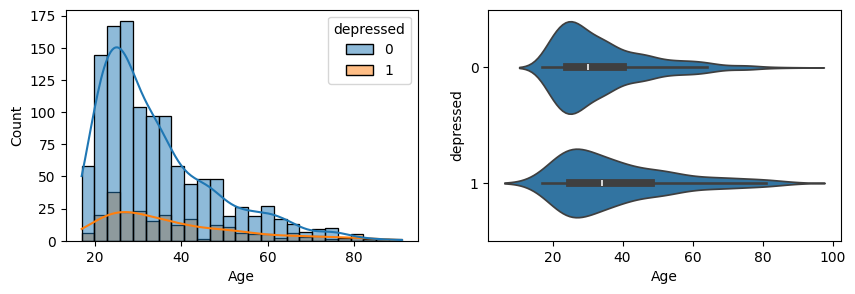

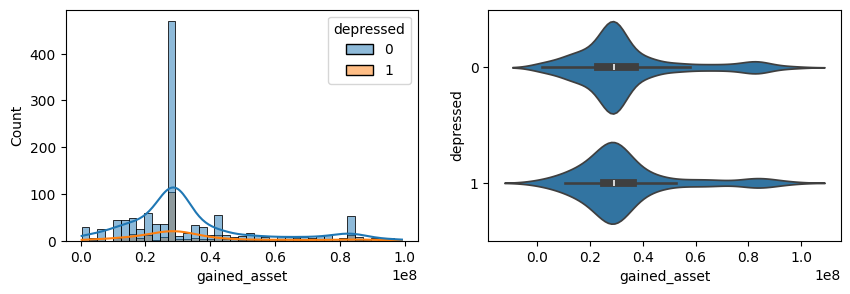

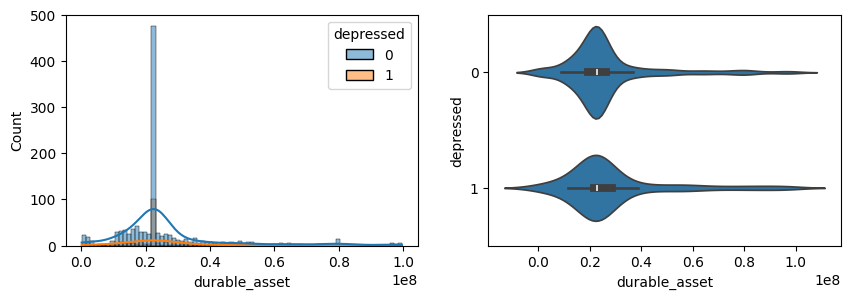

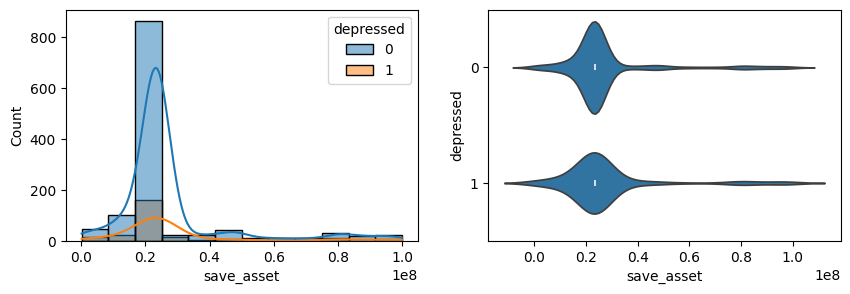

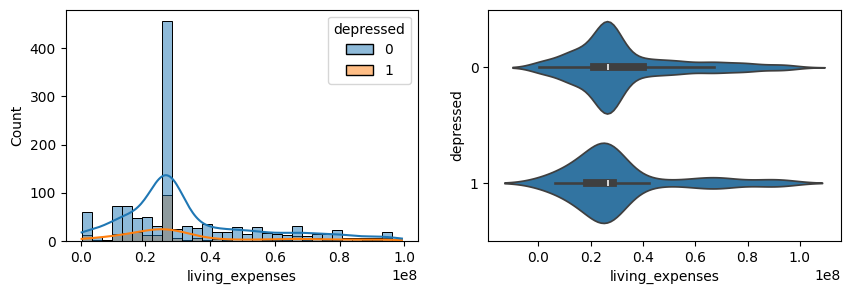

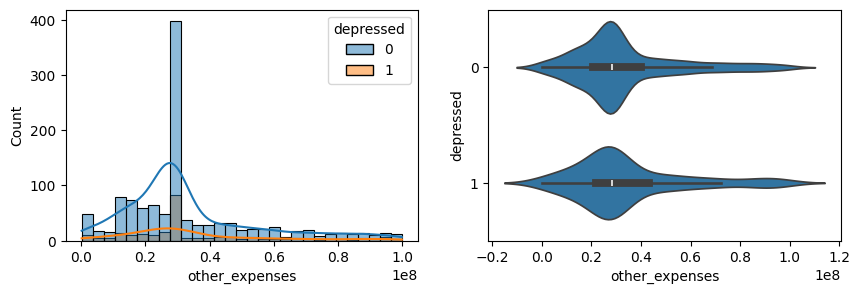

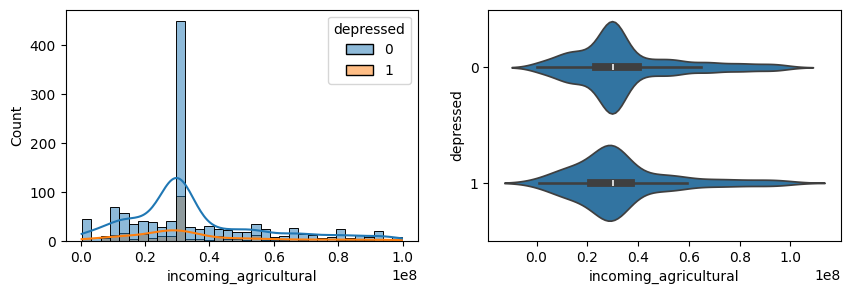

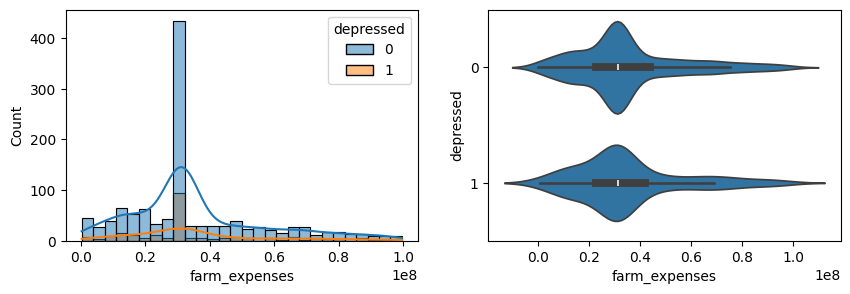

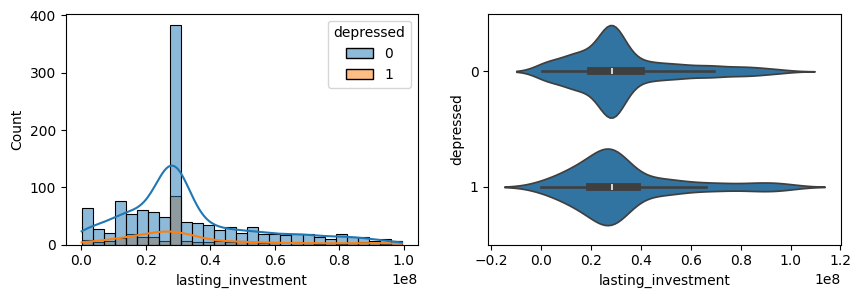

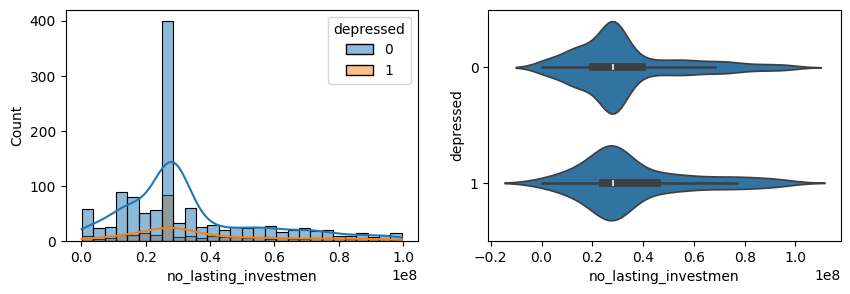

In [17]:
# 2. Variables numéricas.
for col in num_cols:
    plt.figure(figsize=(10,3))
    plt.subplot(1,2,1)
    sns.histplot(data=df_depression, x=col,kde=True, hue='depressed')
    plt.subplot(1,2,2)
    sns.violinplot(data=df_depression, x=col, y='depressed')
    plt.show()

Observando estos últimos gráficos, podemos ver que las distribuciones de los datos cuyo resultado para depresión es positivo o negativo, son parecidas, es decir, cada una de las variables no nos da demasiada información por separado. Ninguna de ellas es distintiva y, viendo las gráficas por separado, no se puede llegar a ninguna conclusión clara en la que se pueda decir que a mayor o menor valor de una variable, más o menos cantidad de personas deprimidas.

Para poder realizar ese tipo de predicciones, al igual que comentábamos con las variables categóricas, va a ser necesario afinar un poco más y desarrollar modelos que relacionen y se fijen en las combinaciones de las distintas variables.

## 3. Modelos Machine Learning

### 3.1 Transformaciones

Pasamos ahora al último punto en el que haremos transformaciones de los datos, para prepararlos para aplicar modelos sobre ellos. 

In [18]:
target = 'depressed'

X = df_depression[cat_cols+num_cols]
y = df_depression[target]

Al tratarse de un diagnóstico médico, vamos a ver si está equilibrado el conjunto de datos:

In [19]:
df_depression.groupby("depressed").size()

depressed
0    1191
1     238
dtype: int64

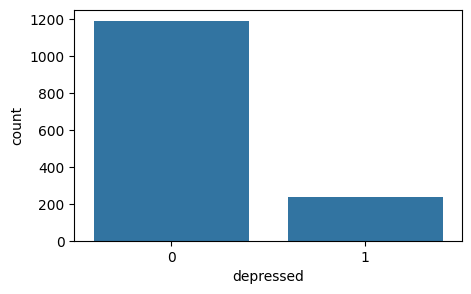

In [20]:
plt.figure(figsize=(5,3))
sns.countplot(data=df_depression, x="depressed")
plt.show()

Vemos que no está demasiado equilibrado, por lo que es conveniente utilizar alguna técnica para balancearlo. En este caso se ha elegido SMOTE para hacerlo:

In [21]:
# Para poder entrenar el smote, tenemos que transformar las variables categóricas para
col_transformer = ColumnTransformer(remainder = 'passthrough', transformers=[
    ("ohe1", OneHotEncoder(drop="first"), cat_cols),
])

label_encoder = LabelEncoder()

X = df_depression[cat_cols+num_cols]
y = df_depression[target]

X_transformed = col_transformer.fit_transform(X)
X_transformed_df = pd.DataFrame(X_transformed, dtype=np.float32)

y_transformed = label_encoder.fit_transform(y)
y_transformed_df = pd.DataFrame(y_transformed, dtype=np.float32)


In [22]:
#Guardamos el column transformer
with open('col_transformer.pkl', 'wb') as f:
    pickle.dump(col_transformer, f)

In [23]:
seed = 444
smote =  SMOTE(random_state=seed)

X_resampled, y_resampled = smote.fit_resample(X_transformed_df, y_transformed_df)
print("y_test: ")
print("Número de 0's", np.count_nonzero(y_resampled == 0))
print("Número de 1's", np.count_nonzero(y_resampled == 1))

y_test: 
Número de 0's 1191
Número de 1's 1191


In [24]:
X_resampled.head()

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,28.0,28912200.0,22861940.0,23399980.0,26692284.0,28203066.0,30028818.0,31363432.0,28411718.0,28292708.0
1,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,23.0,28912200.0,22861940.0,23399980.0,26692284.0,28203066.0,30028818.0,31363432.0,28411718.0,28292708.0
2,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,22.0,28912200.0,22861940.0,23399980.0,26692284.0,28203066.0,30028818.0,31363432.0,28411718.0,28292708.0
3,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,27.0,52667108.0,19698904.0,49647648.0,397715.0,44042268.0,22288056.0,18751328.0,7781123.0,69219768.0
4,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,59.0,82606288.0,17352654.0,23399980.0,80877616.0,74503504.0,53384568.0,20731006.0,20100562.0,43419448.0


### 3.2 Selección de modelos

Una vez la tenemos preparados los datos, vamos a probar distintos modelos de clasificación. 

#### 3.2.1 Cuatro modelos sin análisis de parámetros

Comenzaremos probando con una lista de modelos generales, sin alterar sus parámetros, para tantear los resultados:

In [25]:
models = []
models.append(('LR', LogisticRegression(random_state=seed)))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(probability=True)))
models.append(('KNN', KNeighborsClassifier()))
models.append(('DTC', DecisionTreeClassifier(random_state=seed)))
models.append(('PER', Perceptron()))
models.append(('RFC', RandomForestClassifier(random_state=seed)))
models.append(('XGB', XGBClassifier(random_state=seed)))

En este primer análisis, haremos la evaluación con KFolds y observaremos los resultados. Más tarde, se aplicarán los mismos modelos, pero en este caso, ya dividiendo el conjunto de datos en train y test, entrenando solo con el train y evaluando con test.

In [26]:
names = []
results = []

for name, alg in models:
    
    modelo_pipeline = alg
    
    modelo_pipeline.fit(X_resampled,y_resampled)
    
    cv_technique = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed) 
    cv_results = cross_val_score(modelo_pipeline, X_resampled, y_resampled, cv=cv_technique, scoring="accuracy")
    
    names.append(name)
    results.append(cv_results)

Para visualizar los resultados de manera más gráfica y que la comparativa entre modelos se haga más sencilla, utilizamos una función que se encarga de dibujar box plots:

In [27]:
def boxplots_algorithms(results, names):
    plt.figure(figsize=(8,4))
    plt.boxplot(results)
    plt.xticks(range(1,len(names)+1), names)
    plt.show()

Y se lo aplicamos a nuestro caso concreto:

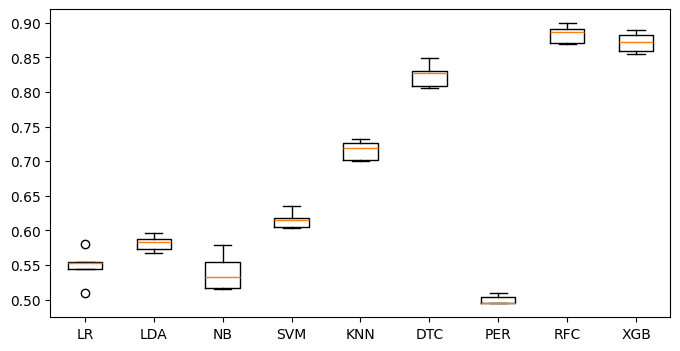

In [28]:
boxplots_algorithms(results, names)

Llegados a este punto, podemos descartar muchos de los modelos y nos quedaremos con el DTC, el RFC y el XGB, que son los tres que tienen una accuracy más alta. Vamos a probar que no se da demasiado overfitting con este tipo de modelos, dividiendo la muestra en train y test y usando como algoritmos de entrada estos tres seleccionados:

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=seed)

In [30]:
models2 = []
models2.append(('XGB', XGBClassifier(random_state=seed)))
models2.append(('RFC', RandomForestClassifier(random_state=seed)))
models2.append(('DTC', DecisionTreeClassifier(random_state=seed)))


names = []
results = []
for name, alg in models2:
    
    modelo_pipeline = alg
    modelo_pipeline.fit(X_train, y_train)

    y_pred_train = modelo_pipeline.predict(X_train)
    y_pred_test = modelo_pipeline.predict(X_test)

    acc_train = accuracy_score(y_true=y_train, y_pred=y_pred_train)
    acc_test = accuracy_score(y_true=y_test, y_pred=y_pred_test)
    
    print(f"Acurracy del train para el modelo {name}:", acc_train)
    print(f"Acurracy del test para el modelo {name}:", acc_test, '\n')

Acurracy del train para el modelo XGB: 0.968503937007874
Acurracy del test para el modelo XGB: 0.8658280922431866 

Acurracy del train para el modelo RFC: 0.9826771653543307
Acurracy del test para el modelo RFC: 0.8763102725366876 

Acurracy del train para el modelo DTC: 0.9826771653543307
Acurracy del test para el modelo DTC: 0.8029350104821803 



Por lo que se ve en este caso, con el algoritmo de DecisionTreeClassifier hay cierto overfitting y además tiene peores resultados que los otros dos. Entre el XGB y el RFC parece que la mejor opción sería el XGB, pues el overfitting es menor y el accuracy para el test es mayor. Aun así, veremos con un grid search y una búsqueda de parámetros si podemos mejorar los resultados de los tres algoritmos.

#### 3.2.2 GridSearch
Pasamos a la segunda y última parte de nuestro proceso de selección de modelos, en la que nos encargaremos de buscar la mejor combinación de parámetros para el Random Forest, ya que tenía muy buenos resultados y podríamos combatir el overfitting con una elección adecuada de parámetros. También haremos lo propio con el Decission Tree Classifier, por si mejoran sus resultados, a pesar que lo habíamos descartado en un primer momento. Finalmente, haremos un grid search con el xgboost por los mismos motivos que para el Decision Tree:

**A. Grid Search de Random Forest Classifier** 

In [31]:
cv_technique = StratifiedKFold(n_splits=5,shuffle = True, random_state=seed)

model_pipeline = RandomForestClassifier(random_state=seed)



params = {
    'n_estimators' : [35,50,65],
    'max_depth': [6, 7, 9],
    'bootstrap': [True, False],
    'min_samples_leaf' : [6, 7, 9],
    'min_samples_split': [3, 4],
    'criterion': ["gini", "entropy"]
}


grid = GridSearchCV(estimator=model_pipeline, cv=cv_technique, param_grid=params)

grid_model = grid.fit(X_train,y_train)

best_model = grid_model.best_estimator_

print(f'Best score: {grid_model.best_score_:.4f}')

Best score: 0.8646


In [32]:
print(best_model)

RandomForestClassifier(bootstrap=False, max_depth=9, min_samples_leaf=7,
                       min_samples_split=3, n_estimators=65, random_state=444)


**B. Grid Search de Decission Tree Classifier** 

In [33]:
cv_technique = StratifiedKFold(n_splits=5,shuffle = True, random_state=seed)

model_pipeline = DecisionTreeClassifier(random_state=seed)

params = {
    'max_depth': [32, 35, 40],
    'min_samples_split': [ 7, 10,15],
    'criterion': ["gini", "entropy"]
}

grid = GridSearchCV(estimator=model_pipeline, cv=cv_technique, param_grid=params)

grid_model = grid.fit(X_train,y_train)

best_model = grid_model.best_estimator_

print(f'Best score: {grid_model.best_score_:.4f}')

Best score: 0.8021


In [34]:
print(best_model)

DecisionTreeClassifier(max_depth=32, min_samples_split=10, random_state=444)


**C. Grid Search de XGBoost**

In [35]:
cv_technique = StratifiedKFold(n_splits=5,shuffle = True, random_state=seed)

model_pipeline = XGBClassifier(random_state=seed)

params = {
    'n_estimators': [100,200,300],
    'eta' : [0.1,0.4,0.7],
    'gamma' : [0.1,0.5,1],
    'max_depth': [5, 10]
}

grid = GridSearchCV(estimator=model_pipeline, cv=cv_technique, param_grid=params)

grid_model = grid.fit(X_train,y_train)

best_model = grid_model.best_estimator_

print(f'Best score: {grid_model.best_score_:.4f}')

Best score: 0.8772


In [36]:
print(best_model)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.1, eval_metric=None,
              feature_types=None, gamma=0.1, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, ...)


Entre todos estos modelos, se confirma que el que mejor sale es el XGB, más concretamente con los siguientes parámetros:
- n_estimators: 100
-  eta : 0.4
- gamma : 0.1,
- max_depth: 10

## 4. Evaluación final del modelo escogido

Pasamos a la última parte de este análisis, en la que haremos una evaluación genérica del mejor modelo que se ha encontrado, para poder observar los resultados de manera más recogida:


Área bajo la curva ROC (AUC) para la red 4 en test: 0.87


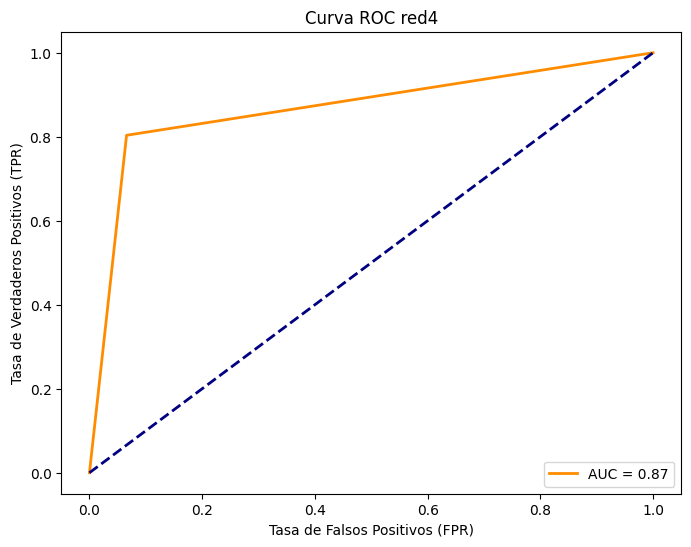

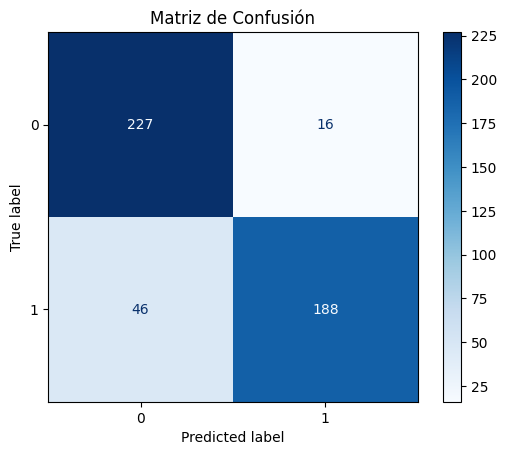

Accuracy del modelo final: 0.870020964360587
Precision del modelo final: 0.9215686274509803
Recall del modelo final: 0.8034188034188035


In [37]:
modelo_final = XGBClassifier(random_state=seed, n_estimators=100, eta=0.4, gamma=0.1, max_depth=10)
modelo_final.fit(X_train, y_train)
y_pred = modelo_final.predict(X_test)

# Área bajo la curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print(f"\nÁrea bajo la curva ROC (AUC) para la red 4 en test: {roc_auc:.2f}")


plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC red4')
plt.legend(loc="lower right")
plt.show()

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Matriz de Confusión')
plt.show()

# Otras métricas
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print(f"Accuracy del modelo final: {accuracy}")
print(f"Precision del modelo final: {precision}")
print(f"Recall del modelo final: {recall}")

In [38]:
# Guardamos el modelo entrenado para su posterior uso

with open('modelo_entrenado.pkl', 'wb') as archivo:
    pickle.dump(modelo_final, archivo)